## Exercise Sheet 7: Variational Autoencoders

In [4]:
import os
import random
import time
import numpy as np
import seaborn as sns

# Import Pytorch, Sklearn
from sklearn.manifold import TSNE
import torch 
import torch.nn as nn
from torch.nn import functional as F

# Load FashionMNIST dataset
from torchvision import datasets, transforms


import matplotlib.pyplot as plt; plt.rcdefaults()
%matplotlib inline

# set figure size
plt.figure(figsize=(10, 5))

<Figure size 1000x500 with 0 Axes>

In [5]:
# set random seed
random.seed(42)
torch.manual_seed(42)

# Set the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

########################
##### HOUSEKEEPING #####

# set hyperparameters
EPOCHS = 7
BATCH_SIZE = 128
LEARNING_RATE = 1e-3
WEIGHT_DECAY = 1e-5

# set directories
RESULTS_DIR = 'results/'
DATA_DIR = 'data/'
MODEL_DIR = 'models/'

########################
########################

# if don't exist, create directories
if not os.path.exists(RESULTS_DIR):
    os.makedirs(RESULTS_DIR)

if not os.path.exists(DATA_DIR):
    os.makedirs(DATA_DIR)

if not os.path.exists(MODEL_DIR):
    os.makedirs(MODEL_DIR)

Using device: cpu


### Define Variational Autoencoder Architecture

In [6]:
class VAE(nn.Module):

    def __init__(self, num_channels=1, num_classes=10, latent_dim=2, embed_dim=16):
        super(VAE, self).__init__()
        
        self.latent_dim = latent_dim
        self.embed_dim = embed_dim

        # Embedding layer
        self.embedding = nn.Embedding(num_embeddings=num_classes, embedding_dim=embed_dim)

        # Encoder
        self.encoder = nn.ModuleList([
            nn.Conv2d(in_channels=num_channels, out_channels=8, kernel_size=3, stride=2, padding=1),
            nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3, stride=2, padding=1),
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=2, padding=1),
        ])

        # Decoder
        self.decoder = nn.ModuleList([
            nn.Conv2d(in_channels=32, out_channels=16, kernel_size=3, padding=1),
            nn.Conv2d(in_channels=16, out_channels=8, kernel_size=3),
            nn.Conv2d(in_channels=8, out_channels=num_channels, kernel_size=3, padding=1),
        ])

        # Fully connected layers for learning representations
        self.fc_latent = nn.Linear(in_features=self.latent_dim + self.embed_dim, out_features=512, bias=True)
        self.fc_mean = nn.Linear(in_features=512 + self.embed_dim, out_features=self.latent_dim, bias=True)
        self.fc_var = nn.Linear(in_features=512 + self.embed_dim, out_features=self.latent_dim, bias=True)

        # Activation functions
        self.leaky_relu = nn.LeakyReLU()
        self.sigmoid = nn.Sigmoid()

    def encode(self, x, y):
        """
        Args:
            x (tensor): Image(s) of shape [B, C, H, W].
            y (tensor): Class label(s) of shape [B,].

        Returns:
            mean (tensor): Mean of shape [B, latent_dim]. 
            log_var (tensor): Log variance of shape [B, latent_dim].
        """
        # Encoder network
        for layer in self.encoder:
            x = layer(x)
            x = self.leaky_relu(x)

        # Flatten
        x = torch.reshape(x, (x.shape[0], -1))
        # Fully connected layers
        class_embed = self.embedding(y)
        # Concat class information
        mean = self.fc_mean(torch.cat((x, class_embed), dim=1))
        log_var = self.fc_var(torch.cat((x, class_embed), dim=1))
        return mean, log_var

    def decode(self, z, y):
        """
        Args:
            z (tensor): Latent variable(s) of shape [B, latent_dim].
            y (tensor): Class label(s) of shape [B,].

        Returns:
            x (tensor): Reconstructed image(s) of shape [B, C, H, W].
        """
        class_embed = self.embedding(y)
        # Concat class information
        x = self.fc_latent(torch.cat((z, class_embed), dim=1))
        x = torch.reshape(x, (-1, 32, 4, 4))
        for layer in self.decoder:
            x = nn.functional.interpolate(x, scale_factor=2, mode='bilinear', align_corners=True)
            x = self.leaky_relu(x)
            x = layer(x)
        x = self.sigmoid(x)
        return x

    def forward(self, x, y):
        """
        Args:
            x (tensor): Image(s) of shape [B, C, H, W].
            y (tensor): Class label(s) of shape [B,].

        Returns:
            x_recon (tensor): Reconstructed image(s) of shape [B, C, H, W].
            mean (tensor): Mean of shape [B, latent_dim]. 
            log_var (tensor): Log variance of shape [B, latent_dim].
        """
        mean, log_var = self.encode(x, y)
        # Reparameterization Trick
        eps = torch.randn(log_var.shape, device=log_var.device)
        z = mean + torch.exp(log_var * 0.5) * eps
        x_recon = self.decode(z, y)
        return x_recon, mean, log_var
    
    def sample(self, y, device):
        """
        Args:
            y (int): Class label.
            device (torch.device): Which device to use (cuda or cpu).

        Returns:
            (tensor): Image of shape [1, C, H, W].
        """
        z = torch.randn((1, self.latent_dim), device=device)
        return self.decode(z, torch.tensor([y], device=device))

    def sample_latent(self, x, y):
        """
        Args:
            x (tensor): Image(s) of shape [B, C, H, W].
            y (tensor): Class label(s) of shape [B,].

        Returns:
            z (tensor): Latent variable(s) of shape [B, latent_dim].
        """
        mean, log_var = self.encode(x, y)
        # Reparameterization Trick
        eps = torch.randn(log_var.shape, device=log_var.device)
        z = mean + torch.exp(log_var * 0.5) * eps
        return z

### Task 1: Training a Variational Autoencoder on MNIST

In [8]:
# Task 1.1 Download the MNIST dataset

mean = (0.1307,)
std = (0.3081,)

transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Resize((32, 32)),
        transforms.RandomRotation(5),
        transforms.Normalize(mean, std)
    ])

# Download and load the training dataset
trainset = datasets.MNIST(DATA_DIR, download=True, train=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=BATCH_SIZE, shuffle=True)

# Download and load the test dataset
testset = datasets.MNIST(DATA_DIR, download=True, train=False, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=BATCH_SIZE, shuffle=False)

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [00:05<00:00, 1770704.65it/s]


Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 237235.82it/s]


Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:00<00:00, 1957087.00it/s]


Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 2137386.82it/s]

Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw



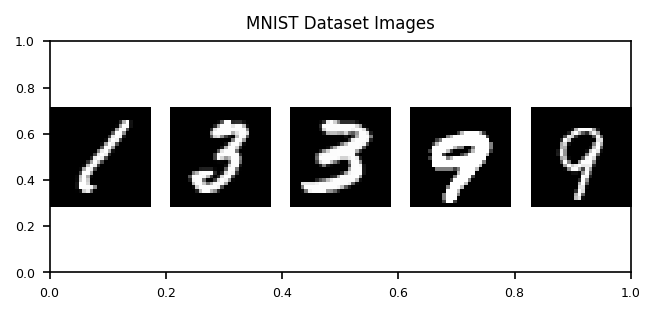

<Figure size 960x720 with 0 Axes>

In [9]:
num_images = 5

# Plot the images from trainloader
plt.figure(figsize=(num_images, 2))
plt.title('Sample Images of MNIST Dataset')
# place it on GPU if available
dataiter = iter(trainloader) 
for i in range(num_images):
    # Get the next batch of images
    images, _ = next(dataiter)

    # Plot the first image in the batch
    plt.subplot(1, num_images, i + 1)
    plt.imshow(images[0].numpy().squeeze(), cmap='gray')
    plt.axis('off')

plt.show()
plt.savefig(RESULTS_DIR + 'mnist_dataset_images.png')

In [10]:
# Task 1.1 Write pytorch code for loss function (BCE + KL Divergence)
#          L(x(i),θ,φ) = −Ez ∼qφ(z|x(i))[log pθ(x(i)|z)] + DKL(qφ(z|x(i)) ∥pθ(z))

def vae_loss(x, x_recon, mean, log_var, KL_weight=1e-3):
    """
    Args:
        x (tensor): Image(s) of shape [B, C, H, W].
        x_recon (tensor): Reconstructed image(s) of shape [B, C, H, W].
        mean (tensor): Mean of shape [B, latent_dim]. 
        log_var (tensor): Log variance of shape [B, latent_dim].

    Returns:
        loss (tensor): Loss value.
    """
    # Ensure the input and output are of the same shape
    assert x.shape == x_recon.shape, "x and x_recon must have the same shape"
    
    # (1) -E[log p(x|z)]: MSE Loss -- Reconstruction loss
    mse_loss = F.mse_loss(x_recon, x, reduction='sum')
    # (2) DKL(q(z|x) || p(z)): KL Divergence -- Regularization loss
    kl_loss = -0.5 * torch.sum(1 + log_var - mean.pow(2) - log_var.exp())
    # Total loss -- balance between the two (lower KL weight for better reconstruction)
    loss = mse_loss + KL_weight * kl_loss
    return loss

In [14]:
def reconstruction_loss(x, x_recon):
    """
    Args:
        x (tensor): Image(s) of shape [B, C, H, W].
        x_recon (tensor): Reconstructed image(s) of shape [B, C, H, W].
        mean (tensor): Mean of shape [B, latent_dim]. 
        log_var (tensor): Log variance of shape [B, latent_dim].

    Returns:
        loss (tensor): Loss value.
    """
    # Ensure the input and output are of the same shape
    assert x.shape == x_recon.shape, "x and x_recon must have the same shape"
    
    # MSE Loss -- Reconstruction loss
    mse_loss = F.mse_loss(x_recon, x, reduction='sum')
    return mse_loss

In [13]:
# Task 1.1 Write pytorch code for loss function (BCE + KL Divergence)
#          L(x(i),θ,φ) = −Ez ∼qφ(z|x(i))[log pθ(x(i)|z)] + DKL(qφ(z|x(i)) ∥pθ(z))

def regularization_loss(mean, log_var):
    """
    Args:
        x (tensor): Image(s) of shape [B, C, H, W].
        x_recon (tensor): Reconstructed image(s) of shape [B, C, H, W].
        mean (tensor): Mean of shape [B, latent_dim]. 
        log_var (tensor): Log variance of shape [B, latent_dim].

    Returns:
        loss (tensor): Loss value.
    """
    kl_loss = -0.5 * torch.sum(1 + log_var - mean.pow(2) - log_var.exp())
    return kl_loss

In [15]:
# Task 1.2 Implement the VAE model
vae = VAE(latent_dim=2).to(device)

# Implement the ADAM optimizer
optimizer = torch.optim.Adam(vae.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)

In [16]:
def train(model, optimizer, epochs, trainloader, device, loss_type='total_loss'):
    """
    Train VAE model and plot sample image per class after each epoch.

    Args:
        model (nn.Module): VAE model.
        optimizer (torch.optim): Optimizer.
        epochs (int): Number of epochs.
        trainloader (DataLoader): Training data loader.
        device (torch.device): Which device to use (cuda or cpu).
    
    Returns:
        None
    """
    training_losses = []

    model.train()
    for epoch in range(epochs):
        train_loss = 0
        for i, (images, labels) in enumerate(trainloader):
            x = images.to(device)
            y = labels.to(device)
            
            # Forward pass
            x_recon, mean, log_var = model(x, y)

            # Select the loss function
            if loss_type == 'total_loss':
                loss = vae_loss(x, x_recon, mean, log_var)
            elif loss_type == 'reconstruction_loss':
                loss = reconstruction_loss(x, x_recon)
            elif loss_type == 'regularization_loss':
                loss = regularization_loss(mean, log_var)
            else:
                raise ValueError("Invalid loss type. Choose from ['total_loss', 'reconstruction_loss', 'regularization_loss']")
            
            # Backward pass
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            training_losses.append(loss.item()) 

        # Print the stats
        print(f'Epoch {epoch + 1}/{epochs}, Training Loss: {train_loss / len(trainloader.dataset):.6f}')

        # Plot sample image per class
        sample_images = []
        for i in range(10):
            sample_images.append(model.sample(i, device).cpu().detach().numpy())

        plt.figure(figsize=(10, 1))
        plt.suptitle(f'Epoch {epoch + 1}/{epochs} - Sample Images')
        for i in range(10):
            plt.subplot(1, 10, i + 1)
            plt.imshow(sample_images[i].squeeze(), cmap='gray')
            plt.axis('off')
        plt.show()
        plt.savefig(RESULTS_DIR + f'sample_images_epoch_{epoch + 1}.png')
    
    return training_losses

Epoch 1/7, Training Loss: 194.003004


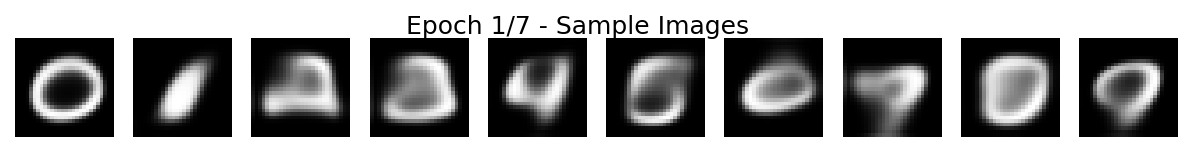

Epoch 2/7, Training Loss: 138.144506


<Figure size 960x720 with 0 Axes>

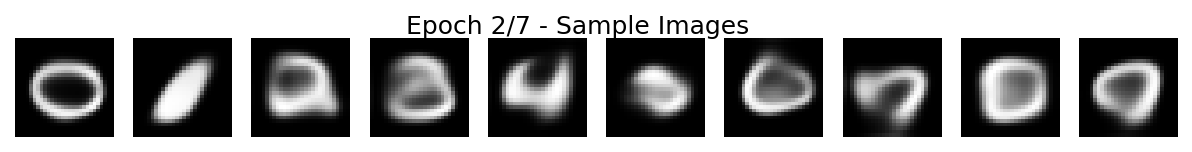

Epoch 3/7, Training Loss: 134.567883


<Figure size 960x720 with 0 Axes>

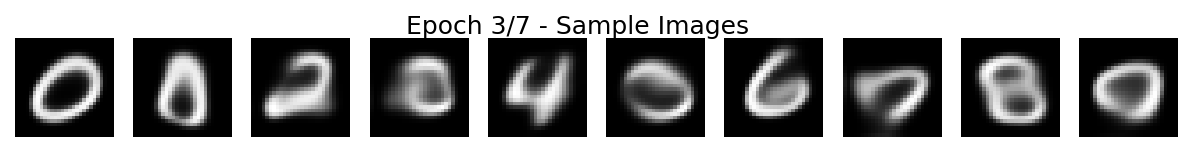

Epoch 4/7, Training Loss: 132.909833


<Figure size 960x720 with 0 Axes>

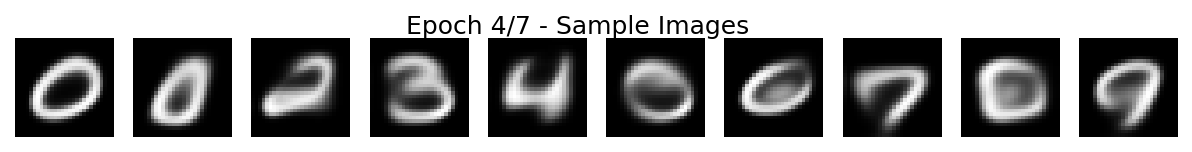

Epoch 5/7, Training Loss: 131.950459


<Figure size 960x720 with 0 Axes>

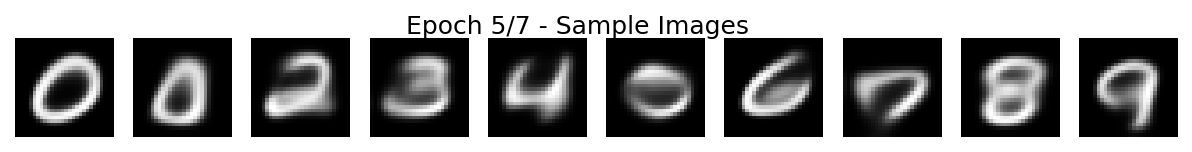

Epoch 6/7, Training Loss: 131.232240


<Figure size 960x720 with 0 Axes>

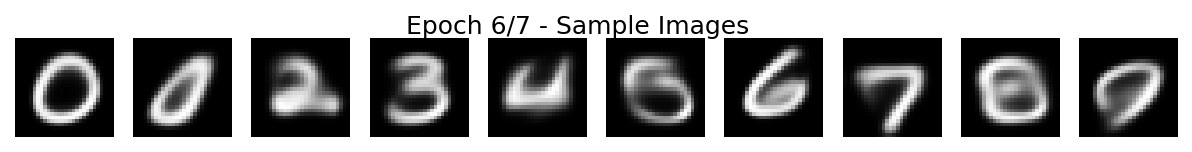

Epoch 7/7, Training Loss: 130.682452


<Figure size 960x720 with 0 Axes>

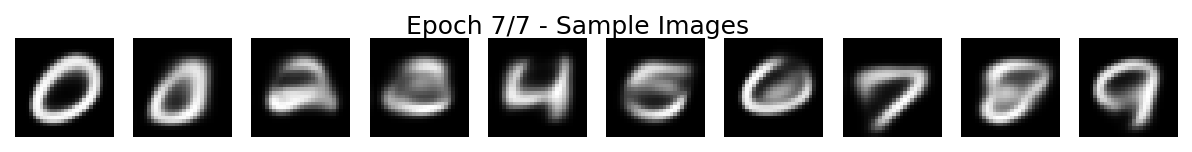

<Figure size 960x720 with 0 Axes>

In [17]:
# train the VAE model
training_losses = train(vae, optimizer, EPOCHS, trainloader, device)

In [18]:
# Task 1.3 Plot the training curve (loss) of the VAE model with epochs on x-axis and loss on y-axis

def plot_loss_curve(training_losses, figsize=(5, 3), file_name='training_loss_curve'):
    """ Plot the training loss curve."""
    plt.figure(figsize=figsize)
    plt.plot(training_losses)
    plt.title('Training Loss Curve')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.tight_layout()
    plt.show()
    plt.savefig(RESULTS_DIR + file_name + '.png')

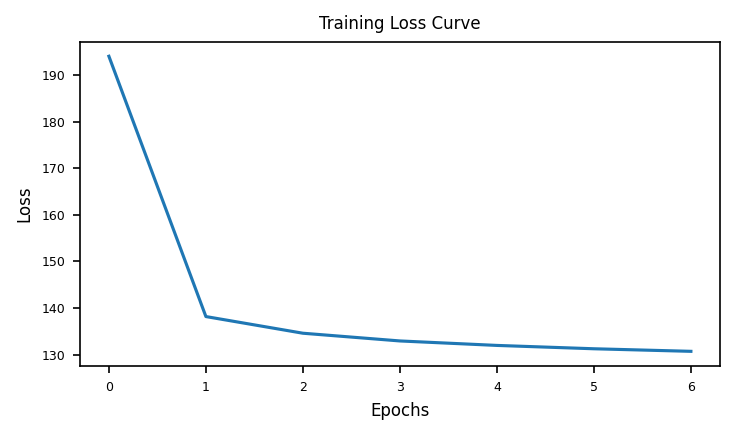

<Figure size 960x720 with 0 Axes>

In [19]:
# Plot the training curve
plot_loss_curve(training_losses, figsize=(5, 3), file_name='vae_training_loss_curve')

### Task 2: Visualize the latent space

Epoch 1/7, Training Loss: 186.668833


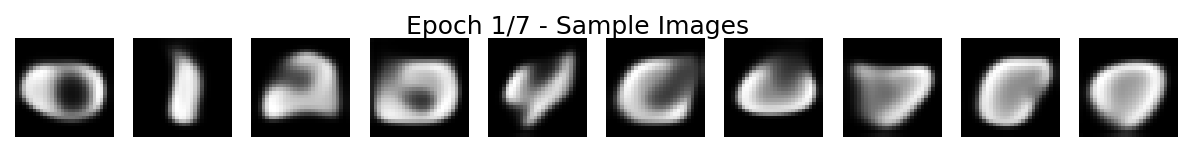

Epoch 2/7, Training Loss: 138.399085


<Figure size 960x720 with 0 Axes>

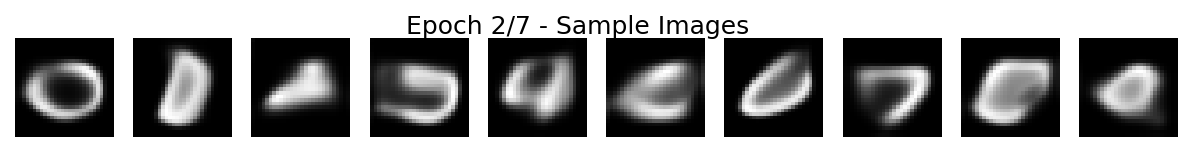

Epoch 3/7, Training Loss: 134.174906


<Figure size 960x720 with 0 Axes>

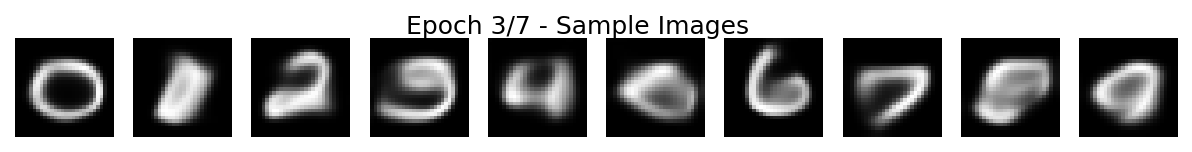

Epoch 4/7, Training Loss: 132.291108


<Figure size 960x720 with 0 Axes>

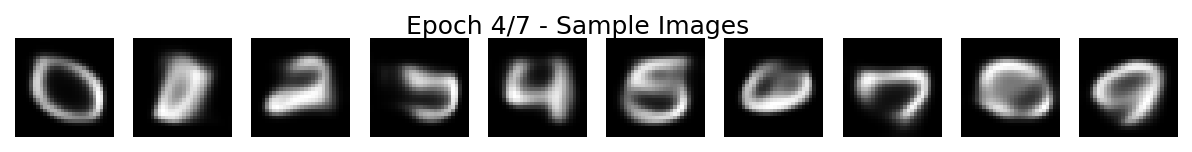

Epoch 5/7, Training Loss: 131.302706


<Figure size 960x720 with 0 Axes>

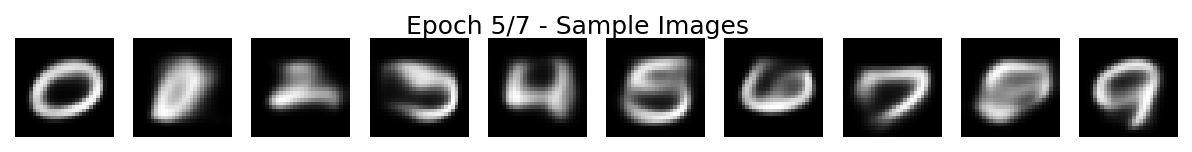

Epoch 6/7, Training Loss: 130.609699


<Figure size 960x720 with 0 Axes>

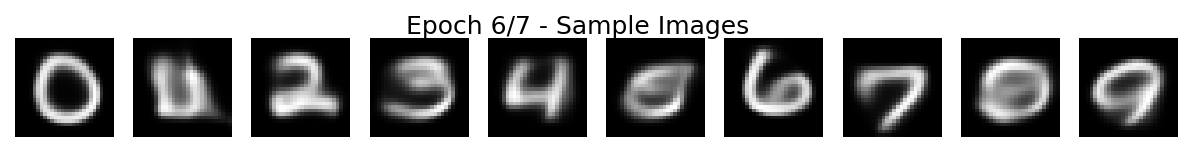

Epoch 7/7, Training Loss: 130.181550


<Figure size 960x720 with 0 Axes>

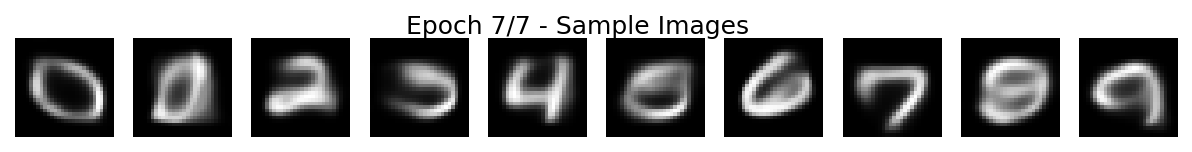

<Figure size 960x720 with 0 Axes>

In [37]:
# Task 2.1 train VAE again using only reconstruction loss
vae_rec = VAE(latent_dim=2).to(device)

# Implement the ADAM optimizer
optimizer = torch.optim.Adam(vae_rec.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)

# train the VAE model with only reconstruction loss
training_losses = train(vae_rec, optimizer, EPOCHS, trainloader, device, loss_type='reconstruction_loss')

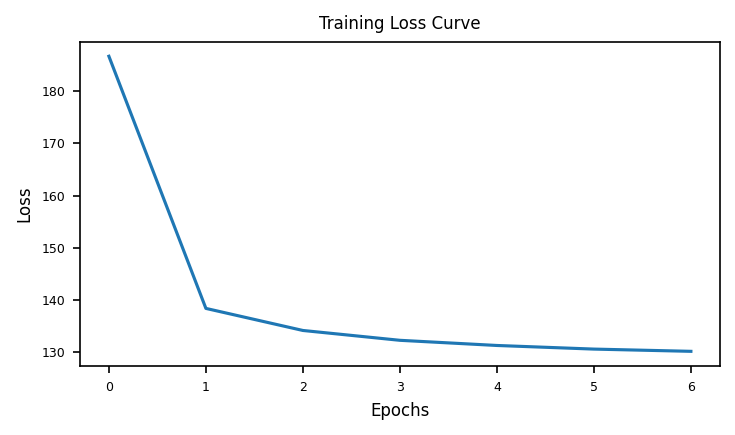

<Figure size 960x720 with 0 Axes>

In [38]:

# Plot the training curve
plot_loss_curve(training_losses, figsize=(5, 3), file_name='vae_rec_training_loss_curve')

Epoch 1/7, Training Loss: 0.000381


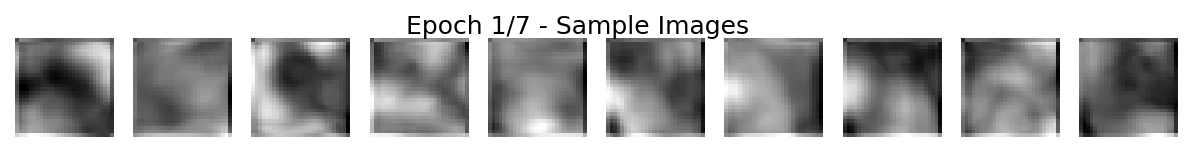

Epoch 2/7, Training Loss: 0.000001


<Figure size 960x720 with 0 Axes>

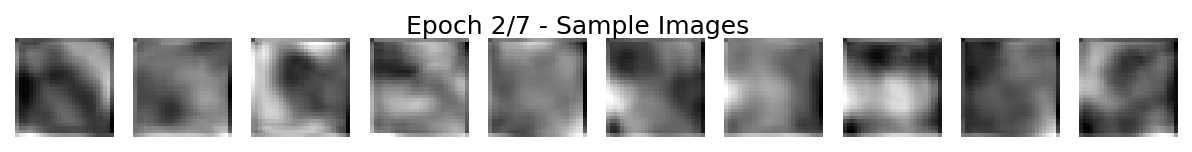

Epoch 3/7, Training Loss: 0.000000


<Figure size 960x720 with 0 Axes>

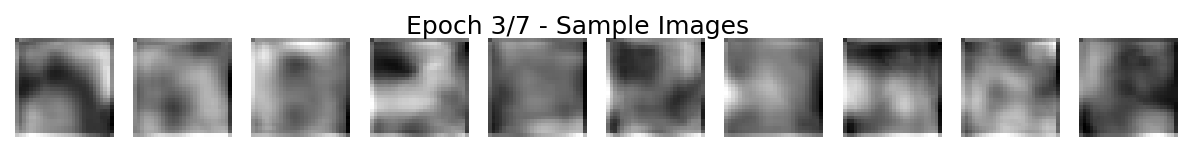

Epoch 4/7, Training Loss: 0.000000


<Figure size 960x720 with 0 Axes>

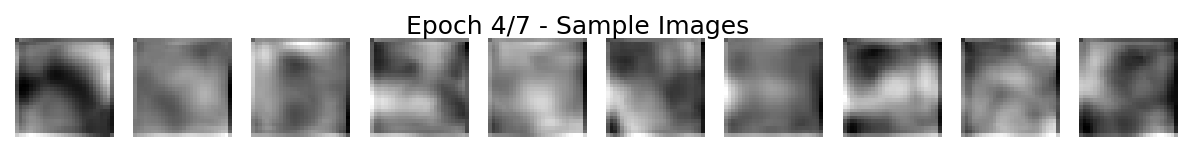

Epoch 5/7, Training Loss: 0.000000


<Figure size 960x720 with 0 Axes>

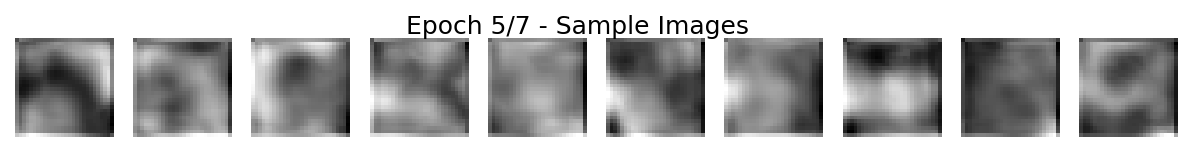

Epoch 6/7, Training Loss: 0.000000


<Figure size 960x720 with 0 Axes>

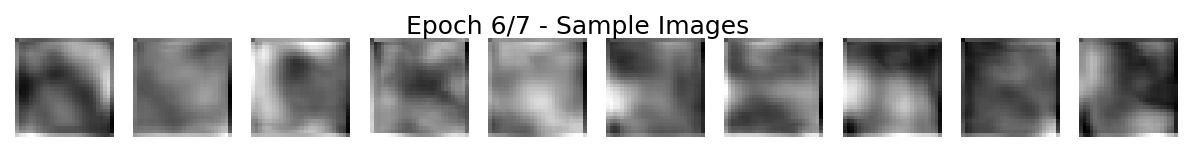

Epoch 7/7, Training Loss: 0.000000


<Figure size 960x720 with 0 Axes>

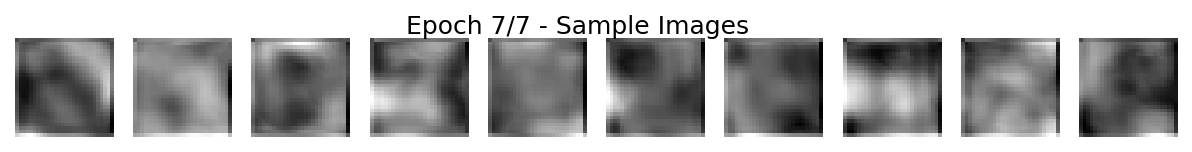

<Figure size 960x720 with 0 Axes>

In [39]:
# Task 2.2 train VAE again using only regularization loss (KL-divergence)
vae_reg = VAE(latent_dim=2).to(device)

# Implement the ADAM optimizer
optimizer = torch.optim.Adam(vae_reg.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)

# Train the model
training_losses = train(vae_reg, optimizer, EPOCHS, trainloader, device, loss_type='regularization_loss')

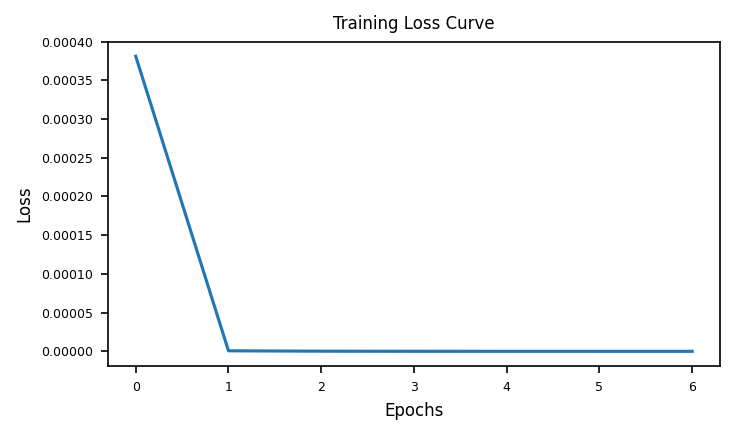

<Figure size 960x720 with 0 Axes>

In [40]:

# Plot the training curve
plot_loss_curve(training_losses, figsize=(5, 3), file_name='vae_reg_training_loss_curve')

Epoch 1/7, Training Loss: 195.791238


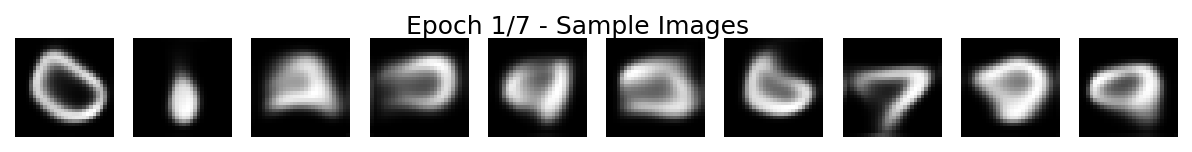

Epoch 2/7, Training Loss: 137.516372


<Figure size 960x720 with 0 Axes>

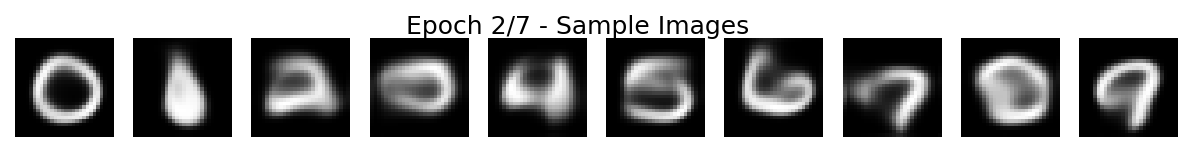

Epoch 3/7, Training Loss: 133.515400


<Figure size 960x720 with 0 Axes>

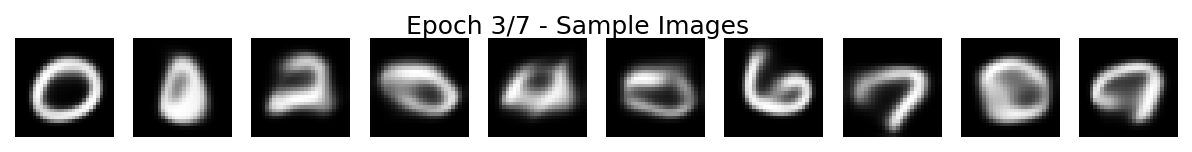

Epoch 4/7, Training Loss: 131.846455


<Figure size 960x720 with 0 Axes>

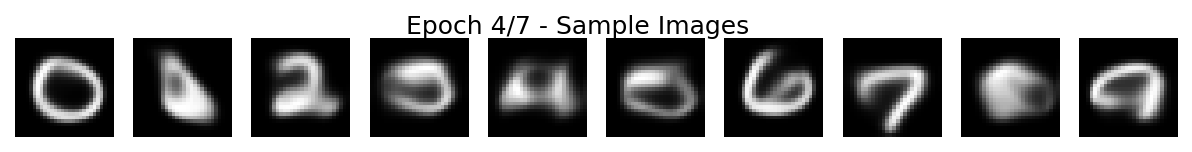

Epoch 5/7, Training Loss: 130.893433


<Figure size 960x720 with 0 Axes>

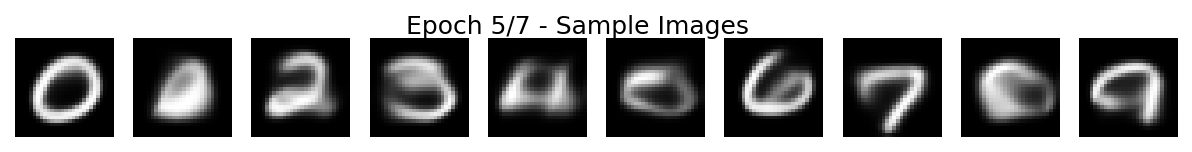

Epoch 6/7, Training Loss: 130.347532


<Figure size 960x720 with 0 Axes>

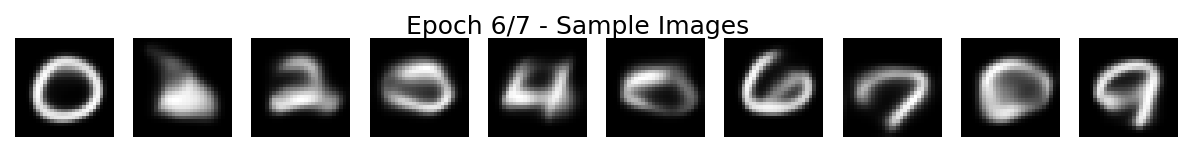

Epoch 7/7, Training Loss: 129.867220


<Figure size 960x720 with 0 Axes>

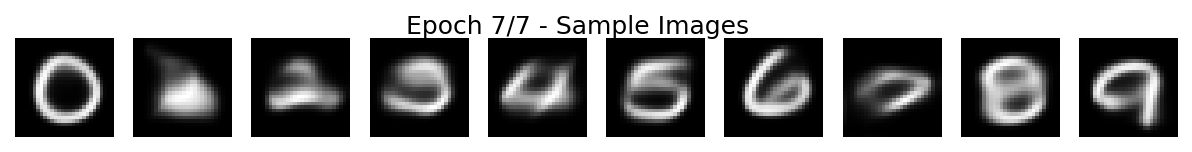

<Figure size 960x720 with 0 Axes>

In [24]:
# Task 2.3 train VAE again using both reconstruction and regularization loss
vae_t = VAE(latent_dim=2).to(device)


# Implement the ADAM optimizer
optimizer = torch.optim.Adam(vae_t.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)

# Train the model
training_losses = train(vae_t, optimizer, EPOCHS, trainloader, device)

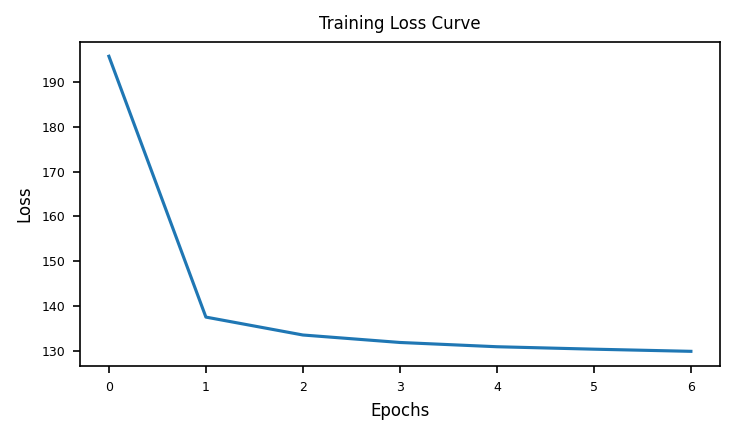

<Figure size 960x720 with 0 Axes>

In [25]:
plot_loss_curve(training_losses, figsize=(5, 3), file_name='vae_total_training_loss_curve')

In [41]:
def plot_latent_space(model, dataloader, n=1000, figsize=(10,5), device=None, file_name='vae_latent_space'):
    """ Posterior sampling based on a given MNIST test image. Extract the latent space and plot it using t-SNE.

    Args:
        vae (nn.Module): VAE model.
        dataloader (DataLoader): Dataloader to use for sampling from the true data distribution.
        n (int): Number of samples to plot.
        figsize (int): Size of the figure.
        method (str): Method to use for projecting the latent space to 2D. Should be 'TSNE'.
        device (torch.device): Device to use for tensor operations.

    Returns:
        None
    """
    if device is None:
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    # Set the model to evaluation mode
    model.eval()

    # Sample a large number of points from the true data distribution and encode to obtain latent space samples
    latents = []
    labels = []
    with torch.no_grad():
        for i, (data, label) in enumerate(dataloader):
            if len(latents) >= n:
                break
            data = data.to(device)
            label = label.to(device)
            latent = vae.sample_latent(data, label)
            latents.append(latent)
            labels.append(label)

        latents = torch.concatenate(latents, dim=0)
        labels = torch.concatenate(labels, dim=0)

    # Plot the latent space as a 2D scatter plot
    sns.scatterplot(x=latents[:, 0].cpu().numpy(), y=latents[:, 1].cpu().numpy(), hue=labels.cpu().numpy(), palette='tab10')
    plt.title('Latent Space')
    plt.xlabel('z1')
    plt.ylabel('z2')

    plt.tight_layout()
    plt.show()
    plt.savefig(RESULTS_DIR + file_name + '.png')


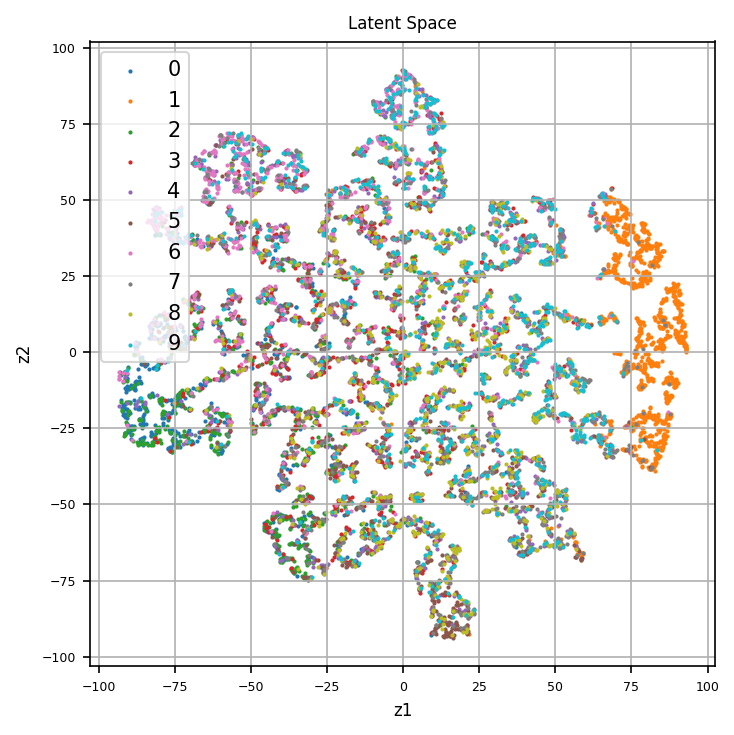

In [42]:
# Visualize the latent space
plot_latent_space(vae, testloader, n=1000, figsize=5, device=device, file_name='vae_latent_space')

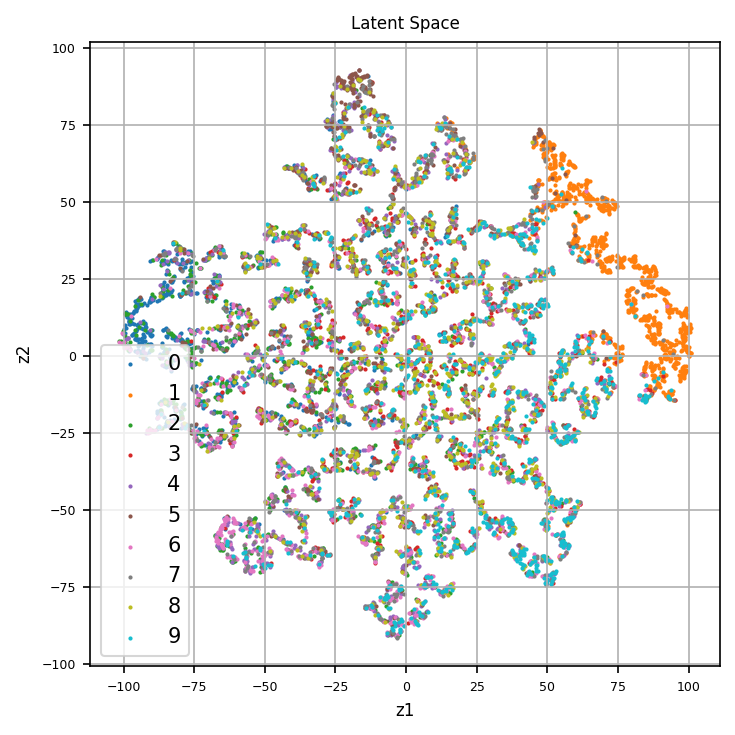

In [43]:
# Visualize the latent space for all three models -- reconstruction loss only
plot_latent_space(vae_rec, testloader, n=1000, figsize=5, device=device, file_name='vae_rec_latent_space')

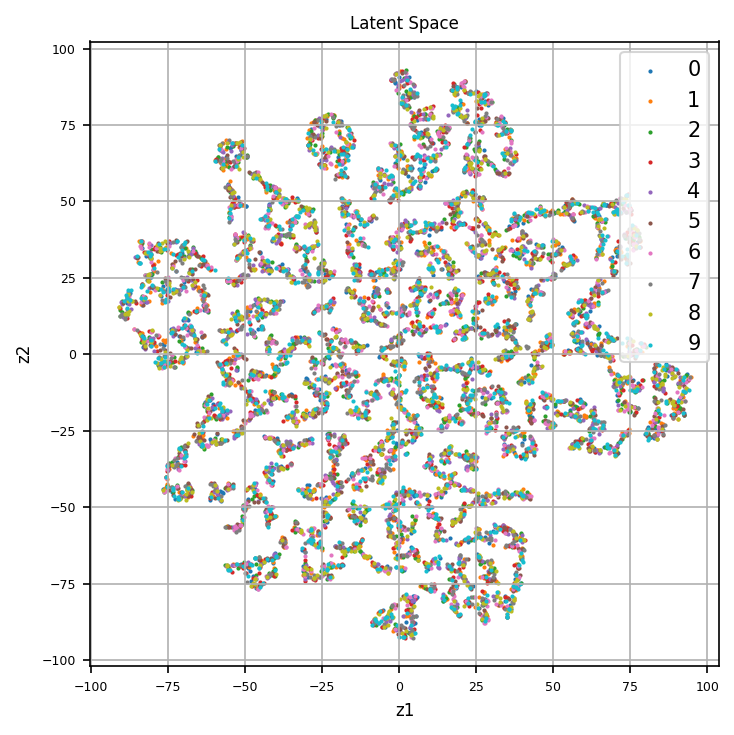

In [44]:
# Visualize the latent space for all three models -- regularization loss only
plot_latent_space(vae_reg, testloader, n=1000, figsize=5, device=device, file_name='vae_reg_latent_space')

**Why can we observe a more homegenous distribution of all classes in the above graph using a loss with KL-Divergence only?**

Ideally, we want overlap between samples that are not very similar, in order to interpolate between classes. However, since there are no limits on what values vectors μ and σ can take on, the encoder can learn to generate very different μ for different classes, clustering them apart, and minimize σ, making sure the encodings themselves don’t vary much for the same sample (that is, less uncertainty for the decoder). But what we ideally want are encodings, all of which are as close as possible to each other while still being distinct, allowing smooth interpolation, and enabling the construction of new samples.

In order to force this, we introduce the Kullback–Leibler divergence (KL divergence[2]) into the loss function. The KL divergence between two probability distributions simply measures how much they diverge from each other. Minimizing the KL divergence here means optimizing the probability distribution parameters (μ and σ) to closely resemble that of the target distribution. For VAEs, the KL loss is equivalent to the sum of all the KL divergences between the component Xi~N(μi, σi²) in X, and the standard normal[3]. It’s minimized when μi = 0, σi = 1.


Intuitively, this loss encourages the encoder to distribute all encodings (for all types of inputs, eg. all MNIST numbers), evenly around the center of the latent space. If it tries to “cheat” by clustering them apart into specific regions, away from the origin, it will be penalized. Using purely KL loss results in a latent space with encodings densely placed randomly in Gaussian manner, near the center of the latent space, with little regard for similarity among nearby encodings. Hence, the decoder finds it impossible to decode anything meaningful from this space since there is no meaning encoded.

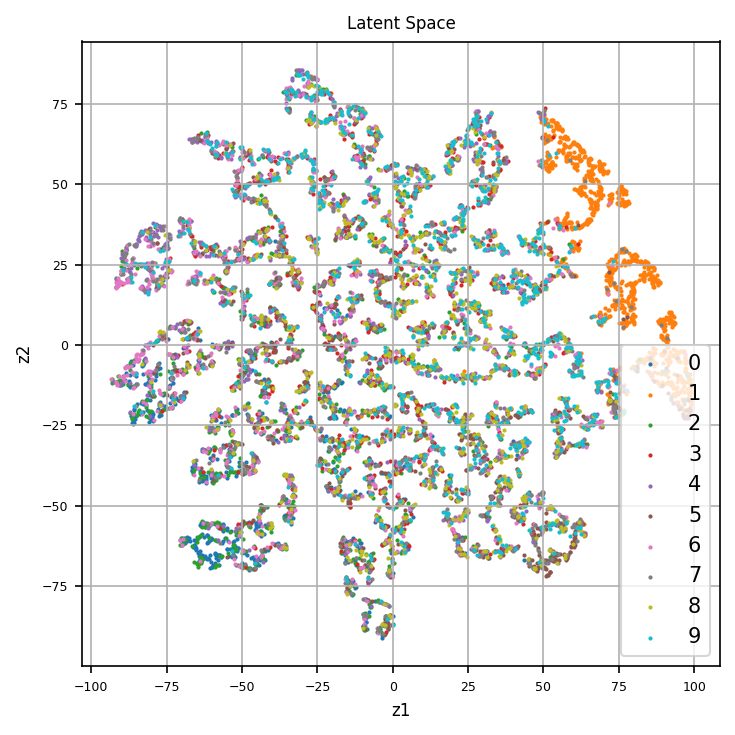

In [45]:
# Visualize the latent space -- total loss
plot_latent_space(vae_t, testloader, n=1000, figsize=5, device=device, file_name='vae_t_latent_space')

**Why can we observe more clustering in the latent space using Reconstruction loss with Regularization loss (KL-Divergence)?**

When optimizing the two together, it results in the generation of a latent space which maintains the similarity of nearby encodings on the local scale via clustering, yet globally, is very densely packed near the latent space origin. Intuitively, this is the equilibrium reached by the cluster-forming nature of the reconstruction loss, and the dense packing nature of the KL loss, forming distinct clusters the decoder can decode.

This means, if one samples a vector from the same prior distribution of the encoded vectors, N(0, I), the decoder will successfully decode it. And if you’re interpolating, there are no sudden gaps between clusters, but a smooth mix of features a decoder can understand.

Simply vector arithmetic in the latent space allows to create those smooth interpolations. For example, if you wish to generate a new sample halfway between two samples, just find the difference between their mean (μ) vectors, and add half the difference to the original, and then simply decode it. What about generating specific features, such as generating glasses on a face? Find two samples, one with glasses, one without, obtain their encoded vectors from the encoder, and save the difference. Add this new “glasses” vector to any other face image, and decode it.

In [46]:
# Plot a grid of samples produced by fixing one latent variable and varying the other

def plot_latent_traversal(vae, device, n=10):
    """ Plot a grid of samples produced by fixing one latent variable and varying the other.

    Args:
        vae (nn.Module): VAE model.
        device (torch.device): Device to use for tensor operations.
        n (int): Number of samples to plot.

    Returns:
        None
    """
    vae.eval()

    # Sample a latent variable based on a standard normal distribution
    z = torch.randn((1, vae.latent_dim), device=device)
    z = z.repeat(n, 1)

    # Plot 10x10 grid of samples
    for i in range(0, n):
        # Select fixed label
        y = torch.tensor([i] * n, device=device)
        
        # Decode the latent variable
        with torch.no_grad():
            samples = vae.decode(z, y)

        # Plot the samples
        plt.figure(figsize=(n, 1))
        for i in range(n):
            plt.subplot(1, n, i + 1)
            plt.imshow(samples[i].squeeze().cpu().numpy(), cmap='gray')
            plt.axis('off')
            # add class label
            plt.title(f'Class: {y[i].item()}')
        plt.show()
        plt.savefig(RESULTS_DIR + f'vae_latent_traversal_{i}.png')


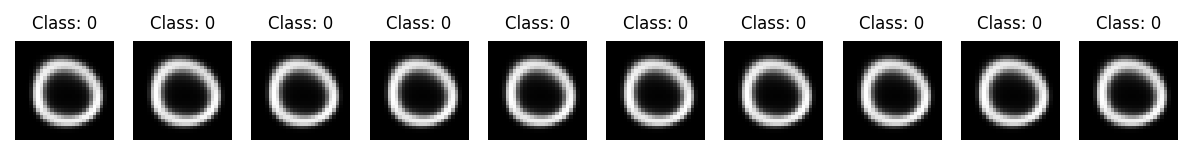

<Figure size 960x720 with 0 Axes>

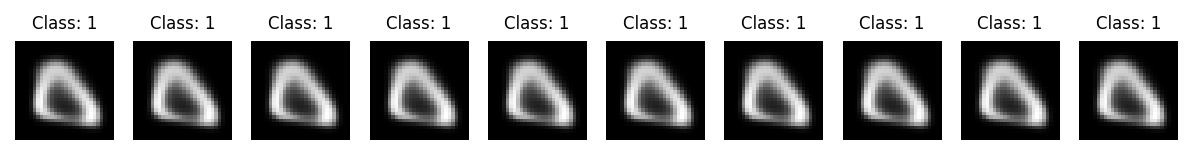

<Figure size 960x720 with 0 Axes>

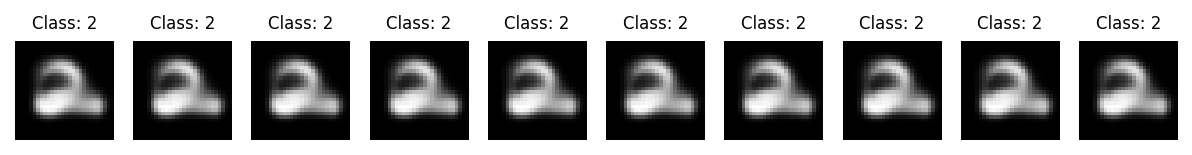

<Figure size 960x720 with 0 Axes>

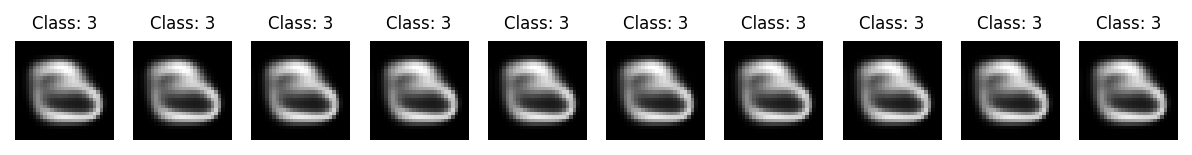

<Figure size 960x720 with 0 Axes>

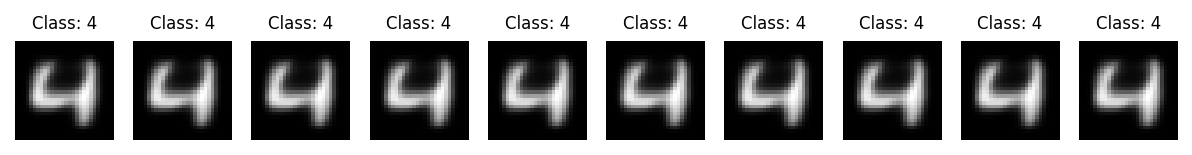

<Figure size 960x720 with 0 Axes>

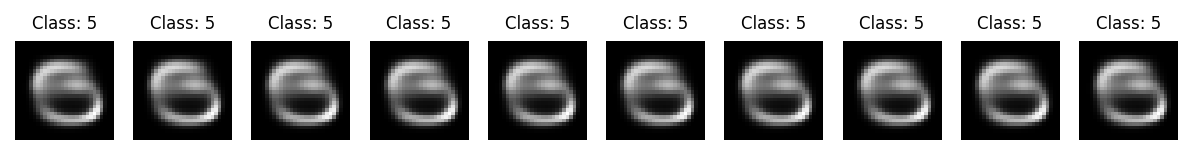

<Figure size 960x720 with 0 Axes>

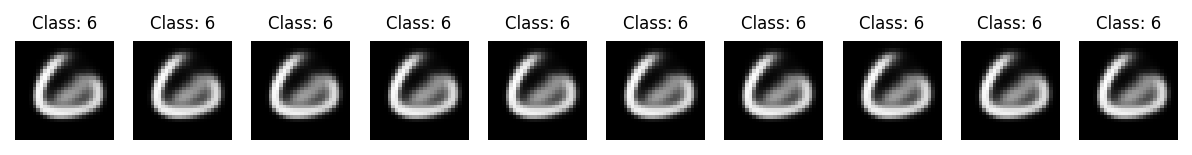

<Figure size 960x720 with 0 Axes>

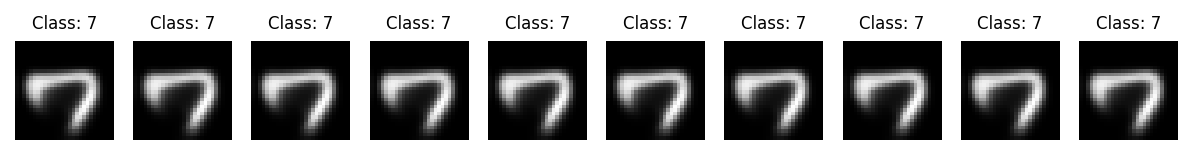

<Figure size 960x720 with 0 Axes>

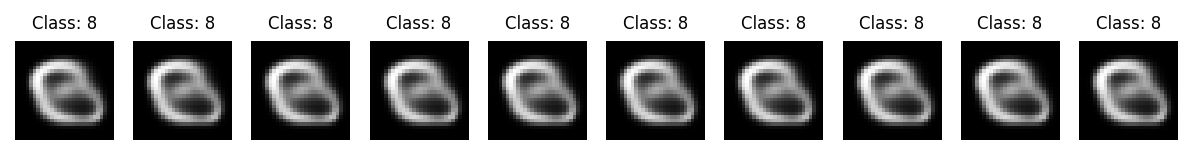

<Figure size 960x720 with 0 Axes>

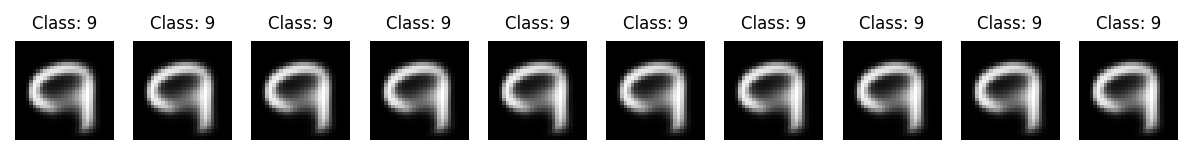

<Figure size 960x720 with 0 Axes>

In [47]:
# Plot the latent traversal
plot_latent_traversal(vae, device, n=10)

### Task 3: Anomaly Detection using a Variational Autoencder

In [48]:
# Task 3.1: Download the Fashion MINST dataset
transform = transforms.Compose([transforms.ToTensor()])

fashion_trainset = datasets.FashionMNIST(DATA_DIR, download=True, train=True, transform=transform)
fashion_trainloader = torch.utils.data.DataLoader(fashion_trainset, batch_size=BATCH_SIZE, shuffle=True)

fashion_testset = datasets.FashionMNIST(DATA_DIR, download=True, train=False, transform=transform)
fashion_testloader = torch.utils.data.DataLoader(fashion_testset, batch_size=BATCH_SIZE, shuffle=False)

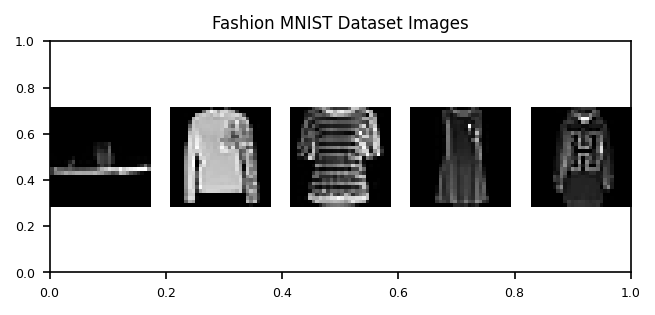

In [49]:
# Plot 5 sample images from trainloader
plt.figure(figsize=(num_images, 2))
plt.title('Fashion MNIST Dataset Images')

dataiter = iter(fashion_trainloader)
for i in range(num_images):
    images, _ = next(dataiter)

    plt.subplot(1, num_images, i + 1)
    plt.imshow(images[0].numpy().squeeze(), cmap='gray')
    plt.axis('off')

In [50]:
def compare_reconstruction_loss(vae, fashion_testloader, mnist_testloader, device, file_name='reconstruction_loss_comparison'):
    """ Anomaly detection identifies data points that deviate significantly from the norm
        Compare the reconstruction loss between MNIST and Fashion MNIST datasets.

    Args:
        vae (nn.Module): VAE model.
        trainloader (DataLoader): Training data loader.
        testloader (DataLoader): Test data loader.
        device (torch.device): Which device to use (cuda or cpu).

    Returns:
        None
    """
    vae.eval()
    imgs_mnist = []
    imgs_fashion = []
    rec_loss_mnist = []
    rec_loss_fashion = []

    # Compute the reconstruction loss for MNIST dataset
    for i, (images, labels) in enumerate(mnist_testloader):
        images = images.to(device)
        labels = labels.to(device)
        x_recon, mean, log_var = vae(images, labels)
        loss = reconstruction_loss(images, x_recon)
        rec_loss_mnist.append(loss.item())
        imgs_mnist.append(images.cpu().detach().numpy())

    # Compute the reconstruction loss for Fashion MNIST dataset
    for i, (images, labels) in enumerate(fashion_testloader):
        images = images.to(device)
        labels = labels.to(device)
        x_recon, mean, log_var = vae(images, labels)
        loss = reconstruction_loss(images, x_recon)
        rec_loss_fashion.append(loss.item())
        imgs_fashion.append(images.cpu().detach().numpy())

    # Plot 10 sample MNIST images and their corresponding reconstruction loss values
    fig, axs = plt.subplots(2, figsize=(10, 5))
    fig.suptitle('MNIST Dataset Images and Reconstruction Loss')

    # Bar chart of reconstruction loss
    axs[0].bar(range(1, 11), rec_loss_mnist[:10])
    axs[0].set_xlabel('Image Index')
    axs[0].set_ylabel('Reconstruction Loss')
    axs[0].set_xticks(range(1, 11))
    # set range for y-axis
    axs[0].set_ylim([0, 120000])

    # Plot a line on top of the bar chart in red connecting each chart element
    axs[0].plot(range(1, 11), rec_loss_mnist[:10], color='red', linewidth=2)

    # MNIST images and their corresponding reconstruction loss values
    for i in range(10):
        ax = plt.subplot(1, 10, i + 1) # create a subplot for each image
        ax.imshow(imgs_mnist[i][0].squeeze(), cmap='gray')
        ax.text(0.5, -0.1, f'Rec. Loss: {rec_loss_mnist[i]:.2f}', ha='center', fontsize=4, color='w', transform=ax.transAxes) # display the reconstruction loss value below the image
        ax.axis('off')

    plt.savefig(f'results/{file_name}_mnist.png')
    plt.show()

    # Plot 10 sample Fashion MNIST images and their corresponding reconstruction loss values
    fig, axs = plt.subplots(2, figsize=(10, 5))
    fig.suptitle('Fashion MNIST Dataset Images and Reconstruction Loss')

    # Bar chart of reconstruction loss
    axs[0].bar(range(1, 11), rec_loss_fashion[:10])
    axs[0].set_xlabel('Image Index')
    axs[0].set_ylabel('Reconstruction Loss')
    axs[0].set_xticks(range(1, 11))
    # set range for y-axis
    axs[0].set_ylim([0, 120000])

    # Plot a line on top of the bar chart in red connecting each chart element
    axs[0].plot(range(1, 11), rec_loss_fashion[:10], color='red', linewidth=2)

    # Fashion MNIST images and their corresponding reconstruction loss values
    for i in range(10):
        ax = plt.subplot(1, 10, i + 1) # create a subplot for each image
        ax.imshow(imgs_fashion[i][0].squeeze(), cmap='gray')
        ax.text(0.5, -0.1, f'Rec. Loss: {rec_loss_fashion[i]:.2f}', ha='center', fontsize=4, color='w', transform=ax.transAxes)
        ax.axis('off')

    plt.savefig(f'results/{file_name}_fashion_mnist.png')
    plt.show()


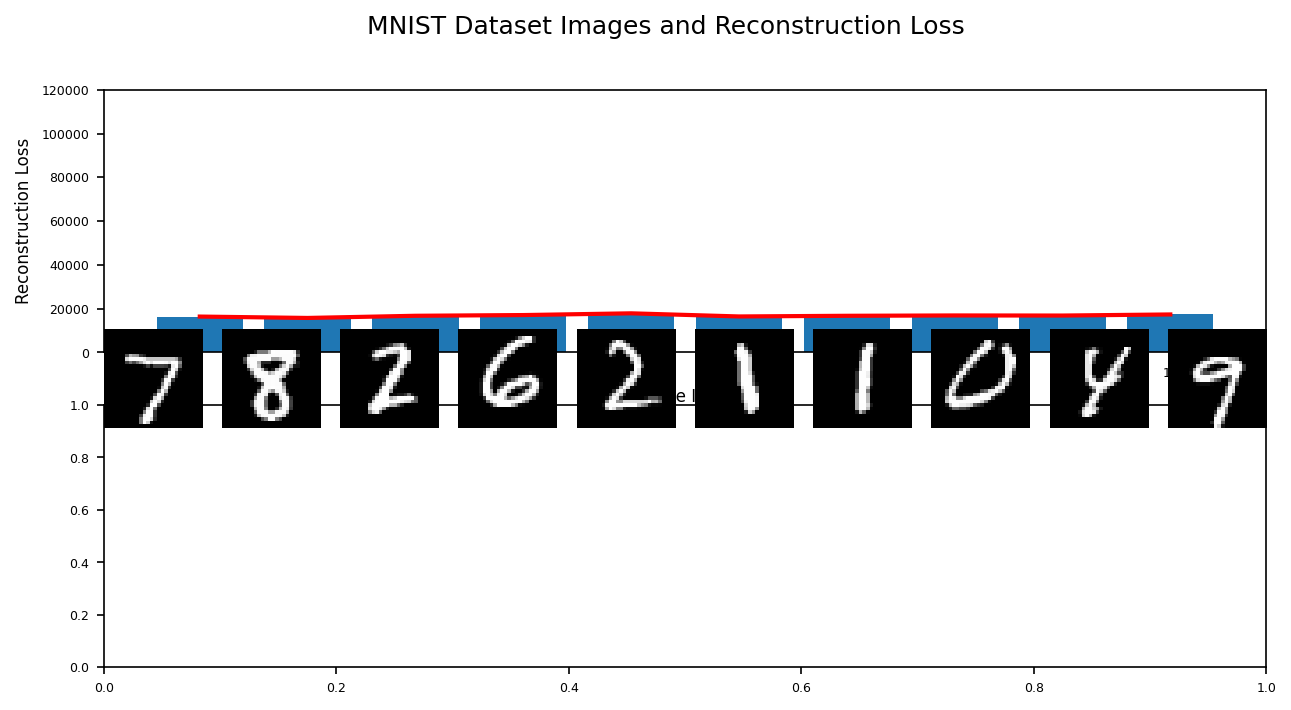

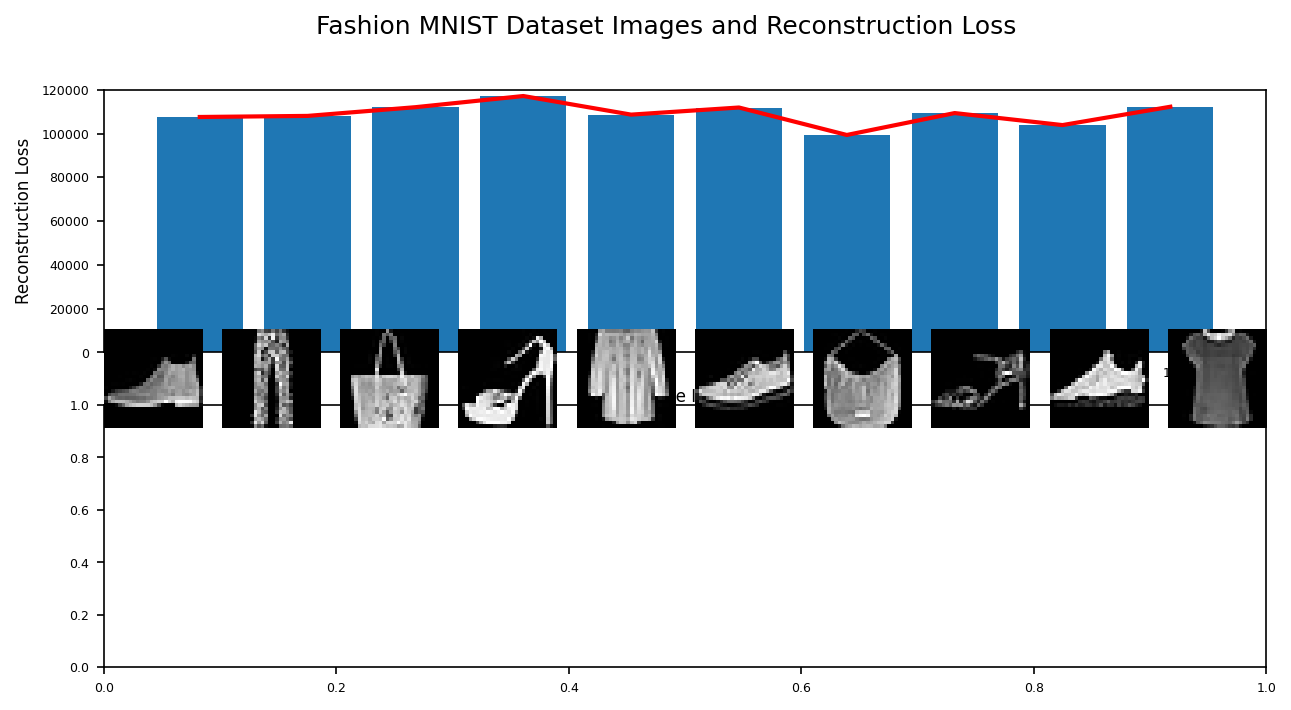

In [51]:
# Compare the reconstruction loss between MNIST and Fashion MNIST datasets
# Use samples from MNIST handwritten digit dataset and the MNIST. fashion dataset to showcase the difference in reconstruction loss. Plot 10 samples of each dataset and their corresponding reconstruction loss.
compare_reconstruction_loss(vae, fashion_testloader, testloader, device, file_name='reconstruction_loss_comparison')